# Problem Defintion

    We want to analyze the historical data on electric vehicle charging sessions to understand the trends and patterns in power demand. Our goal is to forecast future power demand based on historical patterns and to identify the key factors that influence power demand

# Libraries

In [11]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.feature_selection import VarianceThreshold
import geopandas as gpd
from shapely import wkt

# Import necessary libraries
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
# FE / ML Libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder, BinaryEncoder, CatBoostEncoder, HelmertEncoder, SumEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif, f_regression, mutual_info_classif, mutual_info_regression
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.feature_selection import RFE



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, ElasticNet

In [14]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'processed')

# Loading the Data

In [4]:
def data_wetaher():
    data_path = os.path.join(DATA_PATH, 'interim', 'weather', 'df_weather_hourly.csv') #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)

    # Drop 'Unnamed' columns
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data = data.loc[:, ~data.columns.str.contains('Total kWh.1')]
    return data
data = data_wetaher()
# Display all columns
pd.set_option('display.max_columns', None)
data.head()

,Date_Hour,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,geometry,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,2016-01-09 07:00:00,2016-01-09 07:21:00,50994,1,2.084,Leslie Street Car Park,APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,POINT (-3.338015029709677 56.59132102107761),Scotland,2016-01-09 07:00:00,-1.4,-1.4,-1.4,99.90,0.0,0,NaN,0.0,2.00,NaN,0.2,354,990.9,98.4,1.0,0.0,0.0,0,NaN,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
1,2016-01-09 07:00:00,2016-01-09 07:51:00,50281,2,3.870,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,POINT (-3.738820533577715 56.7034231),Scotland,2016-01-09 07:00:00,-1.4,-1.4,-1.4,99.90,0.0,0,NaN,0.0,2.00,NaN,0.2,354,990.9,98.4,1.0,0.0,0.0,0,NaN,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
2,2016-01-09 08:00:00,2016-01-09 08:22:00,50285,1,13.930,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,POINT (-3.4777460635074835 56.386610000000005),Scotland,2016-01-09 08:00:00,-1.4,-1.4,-1.5,99.52,0.0,0,NaN,0.0,2.00,NaN,0.2,354,989.9,98.9,1.4,0.7,0.0,0,NaN,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
3,2016-01-09 08:00:00,2016-01-09 08:54:00,50281,1,10.380,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 16:37:00,19.0,0.0,POINT (-3.738820533577715 56.7034231),Scotland,2016-01-09 08:00:00,-1.4,-1.4,-1.5,99.52,0.0,0,NaN,0.0,2.00,NaN,0.2,354,989.9,98.9,1.4,0.7,0.0,0,NaN,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
4,2016-01-09 09:00:00,2016-01-09 09:22:00,50745,2,3.580,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,POINT (-3.432945 56.2067285),Scotland,2016-01-09 09:00:00,-1.1,-1.1,-1.1,99.85,0.0,0,NaN,0.0,1.96,NaN,0.2,1,989.5,97.0,0.7,12.7,0.0,0,NaN,Overcast,fog,"03144099999,03158099999,03166099999,0317109999..."


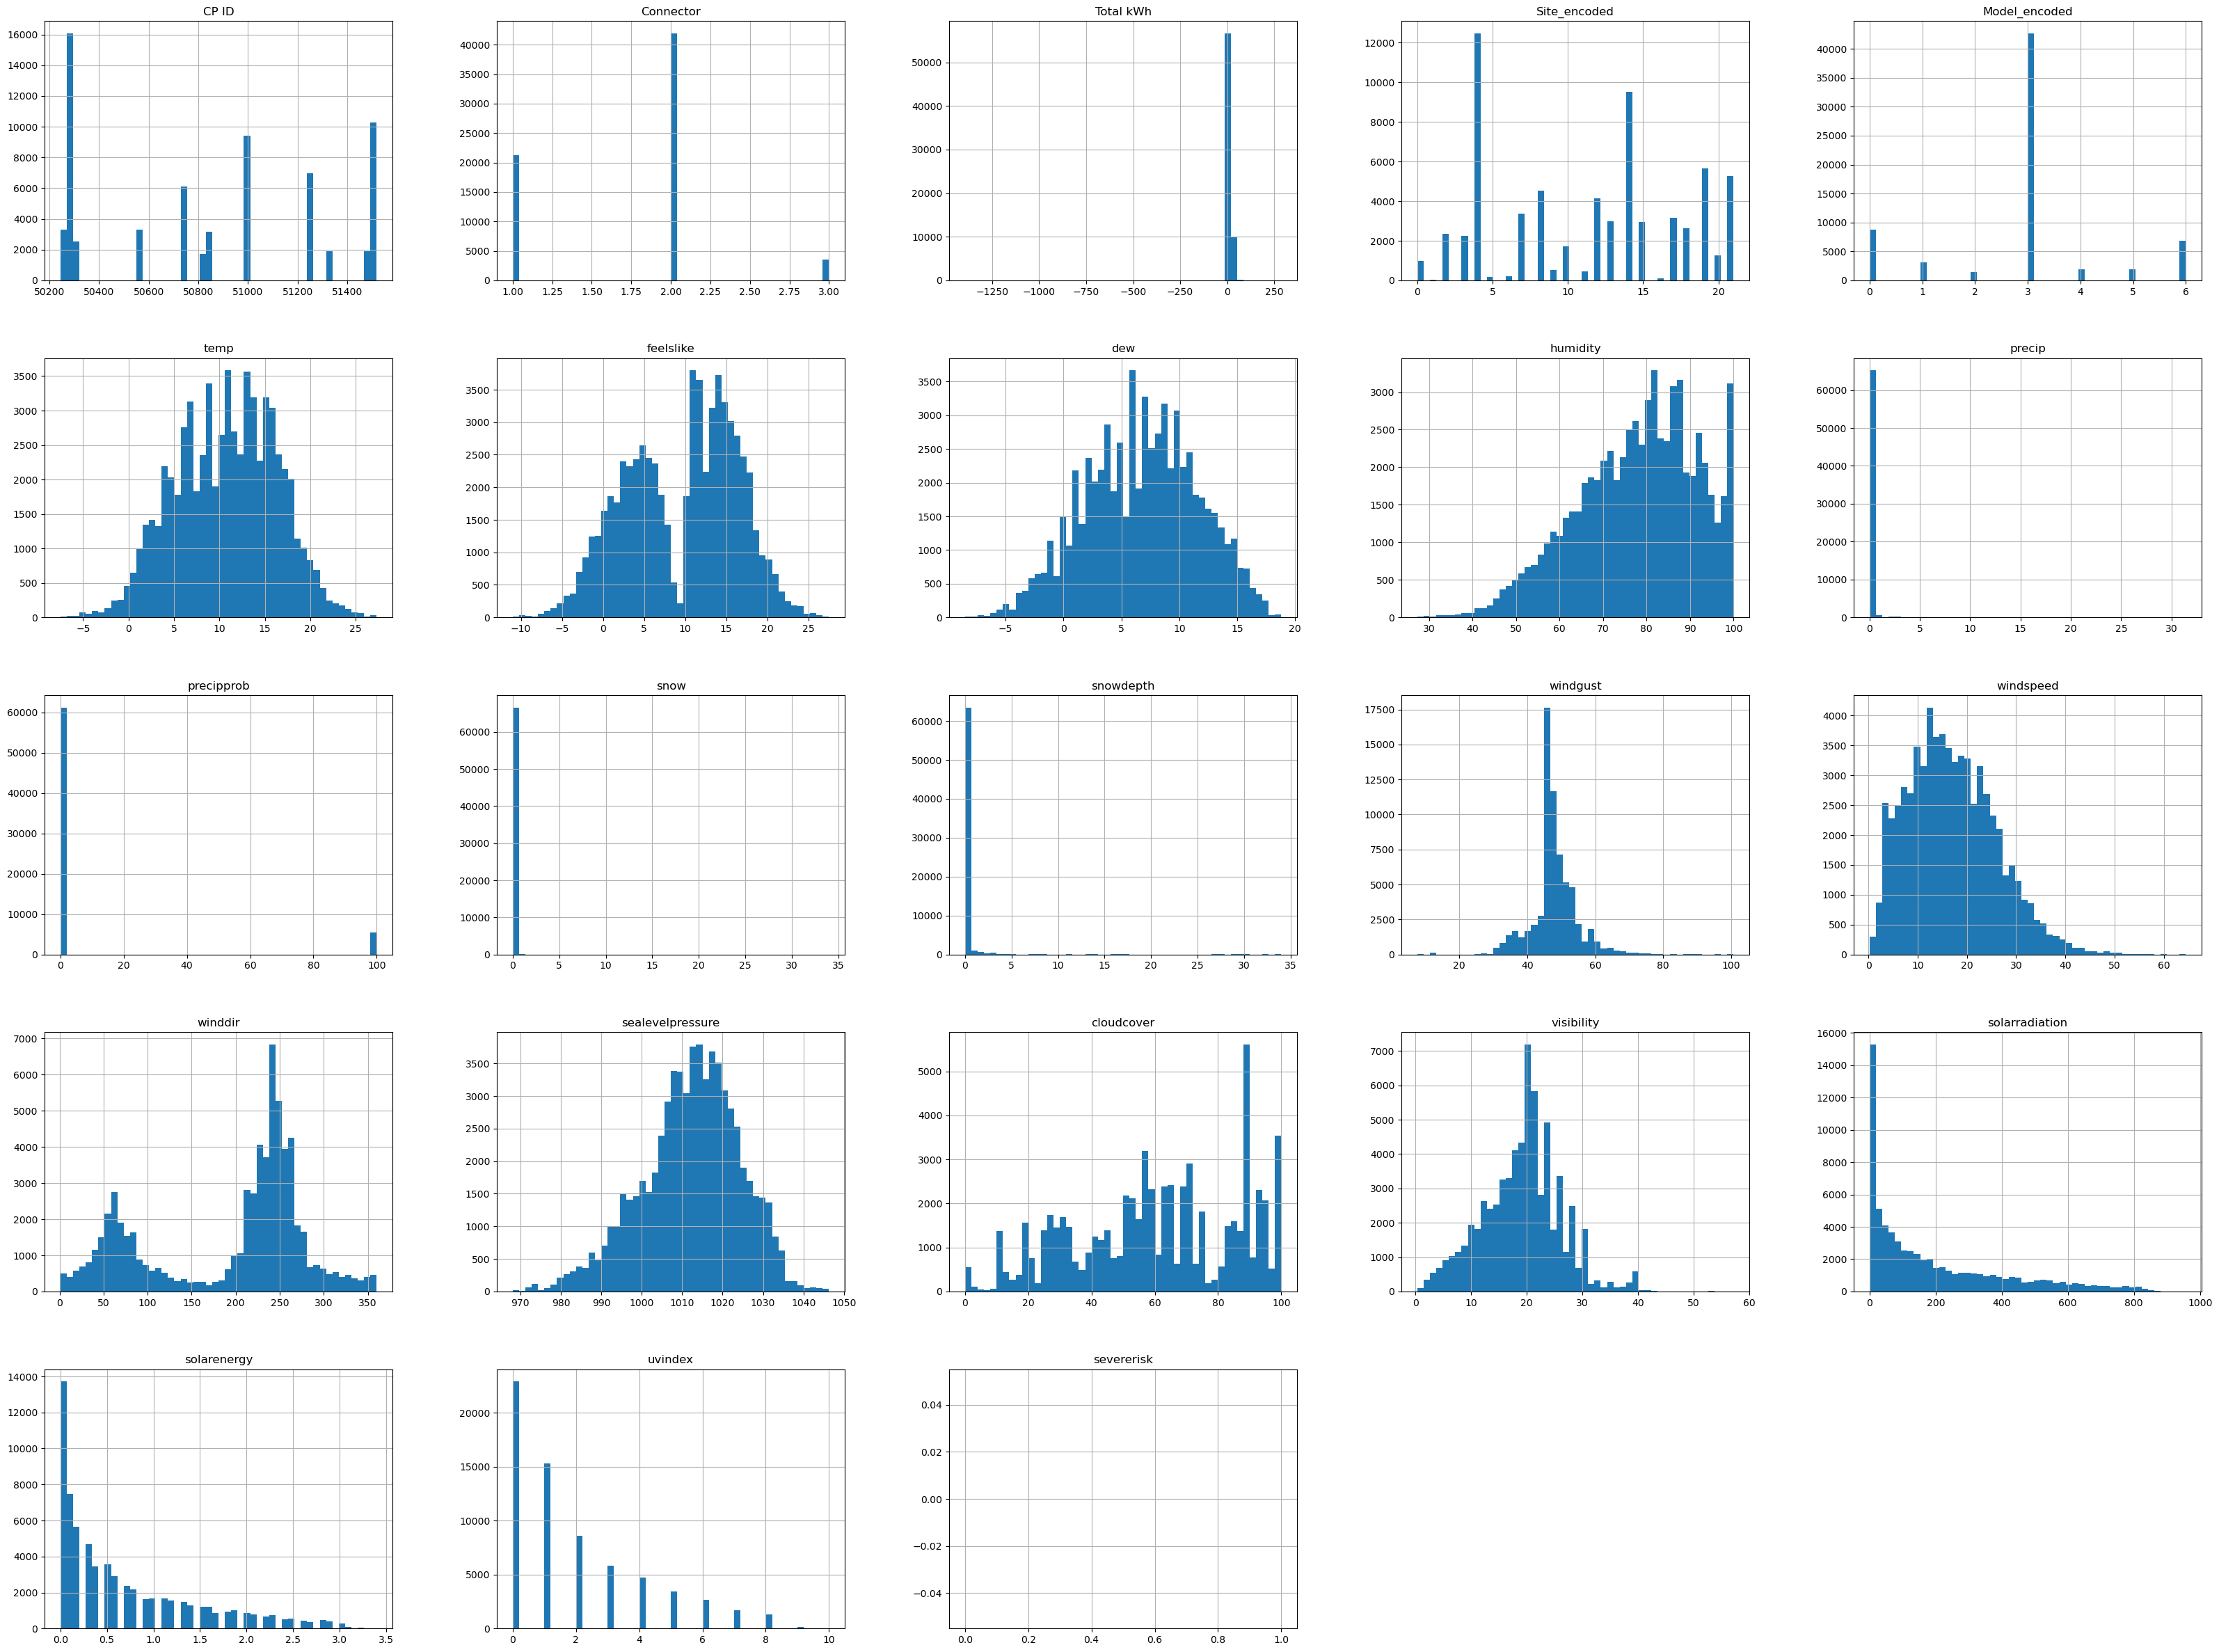

In [5]:
data.hist(bins=50, figsize=(40,30))
plt.show()

# Follwing Steps:

    1. Conduct a Second Round of EDA: Incorporate the new features from the weather and OSM data and understand their effect on the dataset. This might reveal more complex patterns or relationships that were not apparent in the original dataset.

    2. Refine the Machine Learning Model: Based on the insights gained from the new EDA, adjust your machine learning model. This adjustment might include incorporating new features, tweaking model parameters, or even using a different model architecture.

    3. Evaluate the Enhanced Model: Test the performance of the refined model and compare it with the preliminary model. Look for improvements in accuracy, precision, recall, or any other relevant performance metrics.

    4. Iterate Model Refinement and Evaluation: Continue this process of model enhancement and evaluation as needed, until you achieve a satisfactory model performance. Machine learning development is iterative, and each cycle of refinement and evaluation should improve the model's performance.

    5. Document the Final Model: Record the details of the final model, its performance, and any insights gained throughout the process. This documentation is critical for understanding the model's development, for communicating the results to others, and for future reference.

    6. Plan for Future Improvements or Enhancements: Based on observations made during the project, plan for future enhancements. These might include collecting more diverse data, trying more sophisticated modeling techniques, or building a pipeline for continuous model updating and deployment.

## Exploratory Data Analysis

    Understanding the Dataset:

        Check the first few rows of the dataset using the head() function.
        Understand the number of rows and columns using the shape attribute.
        Get the column names using the columns attribute.
        Get information about the datatype of each column, number of non-null entries etc. using the info() function.

    Descriptive Statistics:

        Use the describe() function to get the central tendency, dispersion and shape of the dataset’s distribution.

    Handling Missing Values:

        Check for missing values using the isna() function. You've already done this and you have 185 missing values in 'Total kWh' and 'End DateTime' columns.
        Decide on a strategy to handle the missing values. This could be removing the rows with missing values, or filling the missing values with mean, median, or mode of the rest of the data.

    Visualizing the Dataset:

        Histograms: Plot histograms of each column to visualize the distribution of values.
        Boxplots: Plot boxplots to visualize the spread and skewness of the data.
        Correlation Matrix: Use a correlation matrix or a heatmap to see the correlation between different numeric variables.

    Time Series Specific Analysis:

        Line Plots: Plot the 'Total kWh' against time to visualize how the power demand changes over time.
        Seasonality: Check for seasonality patterns, which are trends that repeat after a specific time interval. This could be daily, weekly, monthly, or annually.
        Trend Analysis: Check if there's a consistent upward or downward slope in the 'Total kWh' over time.
        Decomposition: Decompose the time series to observe its trend, seasonality, and residual components separately.

    Outlier Detection:

        Use scatter plots, boxplots or IQR (interquartile range) methods to identify any outliers in your data.

    Feature Relationships:

        Use scatter plots or pair plots to visualize relationships between different numeric features.
        Visualize the average power demand ('Total kWh') for different categories in 'Site' and 'Model' columns to see if there are any significant differences.

### Understanding the dataset

In [6]:
data.shape

(66664, 35)

In [7]:
data.columns

Index(['Date_Hour', 'Start DateTime', 'CP ID', 'Connector', 'Total kWh',
       'Site', 'Model', 'End DateTime', 'Site_encoded', 'Model_encoded',
       'geometry', 'name', 'datetime', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66664 entries, 0 to 66663
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date_Hour         66664 non-null  object 
 1   Start DateTime    66664 non-null  object 
 2   CP ID             66664 non-null  int64  
 3   Connector         66664 non-null  int64  
 4   Total kWh         66664 non-null  float64
 5   Site              66664 non-null  object 
 6   Model             66664 non-null  object 
 7   End DateTime      66664 non-null  object 
 8   Site_encoded      66664 non-null  float64
 9   Model_encoded     66664 non-null  float64
 10  geometry          66664 non-null  object 
 11  name              66664 non-null  object 
 12  datetime          66664 non-null  object 
 13  temp              66664 non-null  float64
 14  feelslike         66664 non-null  float64
 15  dew               66664 non-null  float64
 16  humidity          66664 non-null  float6

Descriptive Statistics

In [9]:
data.describe()

,CP ID,Connector,Total kWh,Site_encoded,Model_encoded,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66618.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,66664.000000,0.0
mean,50833.965049,1.734264,10.758277,11.416357,2.882815,10.760544,9.593487,6.779716,77.844697,0.077177,8.146826,0.003580,0.248509,48.333737,16.959434,193.072978,1012.215994,60.679344,19.159909,191.427892,0.688381,1.889731,NaN
std,467.454603,0.548223,10.287721,6.181657,1.566628,5.504377,6.715034,4.838335,13.620508,0.695380,27.355494,0.196434,2.065547,6.629877,8.870527,89.021828,12.043630,25.597065,7.016436,209.742339,0.756468,2.127319,NaN
min,50244.000000,1.000000,-1394.711000,0.000000,0.000000,-7.500000,-11.000000,-8.500000,27.330000,0.000000,0.000000,0.000000,0.000000,7.600000,0.200000,1.000000,968.100000,0.000000,0.300000,0.000000,0.000000,0.000000,NaN
25%,50286.000000,1.000000,5.050000,4.000000,3.000000,6.700000,4.000000,3.200000,68.470000,0.000000,0.000000,0.000000,0.000000,46.400000,10.200000,96.000000,1005.200000,41.700000,14.700000,24.000000,0.100000,0.000000,NaN
50%,50838.000000,2.000000,8.750000,13.000000,3.000000,11.000000,11.000000,6.900000,79.520000,0.000000,0.000000,0.000000,0.000000,48.200000,16.100000,230.000000,1013.200000,62.100000,19.800000,111.000000,0.400000,1.000000,NaN
75%,51250.000000,2.000000,14.810000,17.000000,3.000000,14.900000,14.900000,10.300000,87.960000,0.000000,0.000000,0.000000,0.000000,51.800000,23.000000,254.000000,1020.600000,84.600000,23.300000,304.000000,1.100000,3.000000,NaN
max,51519.000000,3.000000,287.710000,21.000000,6.000000,27.300000,27.500000,18.800000,100.000000,31.426000,100.000000,34.000000,34.000000,100.700000,64.500000,360.000000,1046.300000,100.000000,57.200000,957.000000,3.400000,10.000000,NaN


# Data Cleaning   

## Handling NaN values

    This function checks each numeric column, counts the number of NaN values, and if it's higher than 5% of the total rows in the DataFrame, it drops the entire column, else it replaces NaNs with the mean:

In [10]:
data.isna().sum()

Date_Hour               0
Start DateTime          0
CP ID                   0
Connector               0
Total kWh               0
Site                    0
Model                   0
End DateTime            0
Site_encoded            0
Model_encoded           0
geometry                0
name                    0
datetime                0
temp                    0
feelslike               0
dew                     0
humidity                0
precip                  0
precipprob              0
preciptype             26
snow                    0
snowdepth               0
windgust               46
windspeed               0
winddir                 0
sealevelpressure        0
cloudcover              0
visibility              0
solarradiation          0
solarenergy             0
uvindex                 0
severerisk          66664
conditions              0
icon                    0
stations                0
dtype: int64

In [11]:
def drop_nan_columns(df, threshold=0.05):
    """
    Drop columns from df where the proportion of NaN values exceeds the threshold.
    """
    for col in df.columns:
        if df[col].isnull().mean() > threshold:
            df = df.drop(col, axis=1)
            print(f"Dropped column '{col}' due to more than {threshold*100}% missing values.")
    return df


def fill_nan_with_mean(df):
    """
    Fill numeric columns in df with NaN values with the mean value of the column.
    """
    numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
    for col in numeric_cols:
        num_nans = df[col].isnull().sum()
        if num_nans > 0:
            df[col] = df[col].fillna(df[col].mean())
            percentage_nans = (num_nans / df.shape[0]) * 100  # calculate percentage of NaN values
            print(f"Replaced {num_nans} NaN values ({percentage_nans:.2f}%) in column '{col}' with the mean of the column.")
    return df


def fill_nan_with_mode(df):
    """
    Fill categorical columns NaN values with the mode (most frequent value) of the column.
    """
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        num_nans = df[col].isnull().sum()
        if num_nans > 0:
            df[col] = df[col].fillna(df[col].mode()[0])  # replace NaNs with the mode
            percentage_nans = (num_nans / df.shape[0]) * 100  # calculate percentage of NaN values
            print(f"Replaced {num_nans} NaN values ({percentage_nans:.2f}%) in column '{col}' with the mode of the column.")
    return df


def process_nan_values(df, drop_threshold=0.05):
    """
    Process NaN values in a dataframe.
    
    Columns where the proportion of NaNs exceeds drop_threshold are dropped.
    Remaining NaNs in numeric columns are replaced with the column mean.
    """
    df = drop_nan_columns(df, threshold=drop_threshold)
    df = fill_nan_with_mean(df)
    fill_nan_with_mode(df)
    return df


df = process_nan_values(data)

Dropped column 'severerisk' due to more than 5.0% missing values.
Replaced 46 NaN values (0.07%) in column 'windgust' with the mean of the column.
Replaced 26 NaN values (0.04%) in column 'preciptype' with the mode of the column.


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66664 entries, 0 to 66663
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date_Hour         66664 non-null  object 
 1   Start DateTime    66664 non-null  object 
 2   CP ID             66664 non-null  int64  
 3   Connector         66664 non-null  int64  
 4   Total kWh         66664 non-null  float64
 5   Site              66664 non-null  object 
 6   Model             66664 non-null  object 
 7   End DateTime      66664 non-null  object 
 8   Site_encoded      66664 non-null  float64
 9   Model_encoded     66664 non-null  float64
 10  geometry          66664 non-null  object 
 11  name              66664 non-null  object 
 12  datetime          66664 non-null  object 
 13  temp              66664 non-null  float64
 14  feelslike         66664 non-null  float64
 15  dew               66664 non-null  float64
 16  humidity          66664 non-null  float6

In [13]:
X_base = df
y_base = df['Total kWh']
print(X_base.shape)

# Number of unique values for each column
counts = X_base.nunique()
# record columns to delete
single_value = [i for i,v in enumerate(counts) if v == 1]
print(single_value)

(66664, 34)
[11]


In [14]:
y_base

0         2.084000
1         3.870000
2        13.930000
3        10.380000
4         3.580000
           ...    
66659    10.758277
66660    10.080000
66661     4.690000
66662    14.710000
66663     7.930000
Name: Total kWh, Length: 66664, dtype: float64

## Uniqueness

Column 'Date_Hour' has 16937 unique values (25.41%).
Column 'Start DateTime' has 63953 unique values (95.93%).
Column 'CP ID' has 36 unique values (0.05%).
Column 'Connector' has 3 unique values (0.00%).
Column 'Total kWh' has 14088 unique values (21.13%).
Column 'Site' has 18 unique values (0.03%).
Column 'Model' has 7 unique values (0.01%).
Column 'End DateTime' has 63577 unique values (95.37%).
Column 'Site_encoded' has 22 unique values (0.03%).
Column 'Model_encoded' has 7 unique values (0.01%).
Column 'geometry' has 16 unique values (0.02%).
Column 'name' has 1 unique values (0.00%).
Column 'datetime' has 16937 unique values (25.41%).
Column 'temp' has 334 unique values (0.50%).
Column 'feelslike' has 366 unique values (0.55%).
Column 'dew' has 269 unique values (0.40%).
Column 'humidity' has 4826 unique values (7.24%).
Column 'precip' has 633 unique values (0.95%).
Column 'precipprob' has 2 unique values (0.00%).
Column 'preciptype' has 3 unique values (0.00%).
Column 'snow' has 

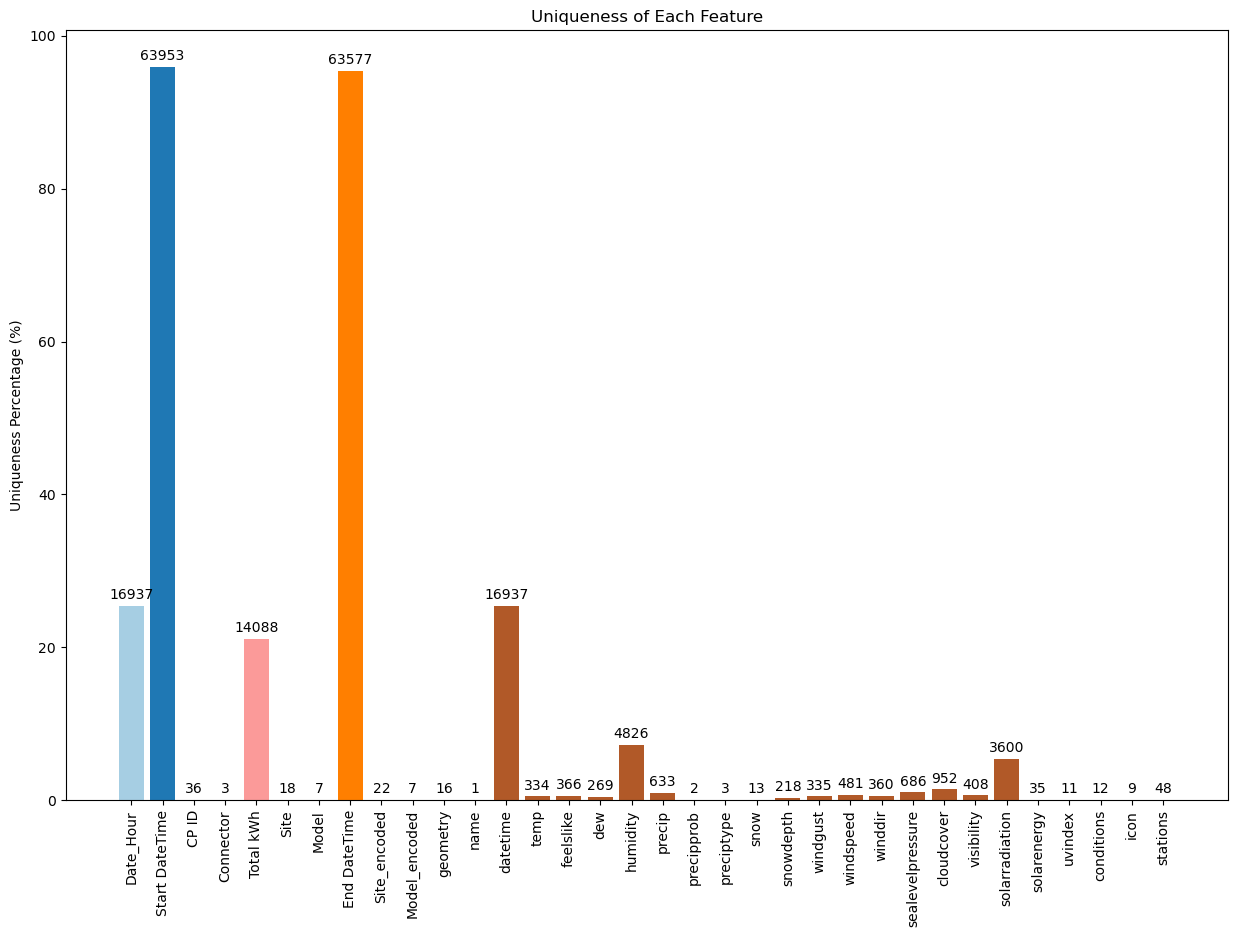

In [15]:
def calculate_uniqueness(df):
    """
    Calculate the uniqueness of each column in a dataframe.
    Returns a dictionary with the percentage of unique values and number of unique values for each column.
    """
    num_rows = df.shape[0]
    uniqueness_dict = {}
    
    for col in df.columns:
        num_unique_values = df[col].nunique()
        uniqueness_percentage = (num_unique_values / num_rows) * 100
        uniqueness_dict[col] = (uniqueness_percentage, num_unique_values)
        print(f"Column '{col}' has {num_unique_values} unique values ({uniqueness_percentage:.2f}%).")
    
    return uniqueness_dict

def plot_uniqueness(uniqueness_dict):
    """
    Plot the percentage of unique values for each feature in a dataframe.
    Also, annotate each bar with the number of unique values.
    """
    # Prepare data for plotting
    labels = uniqueness_dict.keys()
    uniqueness_percentages = [val[0] for val in uniqueness_dict.values()]
    num_unique_values = [val[1] for val in uniqueness_dict.values()]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    bars = ax.bar(labels, uniqueness_percentages, color=plt.cm.Paired(np.arange(len(labels))))
    plt.ylabel('Uniqueness Percentage (%)')
    plt.title('Uniqueness of Each Feature')
    plt.xticks(rotation=90)
    
    # Adding labels to bars
    for bar, unique_count in zip(bars, num_unique_values):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, unique_count, ha='center', va='bottom')

    plt.show()

# Call the functions
uniqueness_dict = calculate_uniqueness(X_base)
plot_uniqueness(uniqueness_dict)



In [16]:
X_base.head()

,Date_Hour,Start DateTime,CP ID,Connector,Total kWh,Site,Model,End DateTime,Site_encoded,Model_encoded,geometry,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,stations
0,2016-01-09 07:00:00,2016-01-09 07:21:00,50994,1,2.084,Leslie Street Car Park,APT Triple Rapid Charger,2016-01-09 07:27:00,0.0,3.0,POINT (-3.338015029709677 56.59132102107761),Scotland,2016-01-09 07:00:00,-1.4,-1.4,-1.4,99.90,0.0,0,rain,0.0,2.00,48.333737,0.2,354,990.9,98.4,1.0,0.0,0.0,0,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
1,2016-01-09 07:00:00,2016-01-09 07:51:00,50281,2,3.870,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 09:01:00,19.0,0.0,POINT (-3.738820533577715 56.7034231),Scotland,2016-01-09 07:00:00,-1.4,-1.4,-1.4,99.90,0.0,0,rain,0.0,2.00,48.333737,0.2,354,990.9,98.4,1.0,0.0,0.0,0,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
2,2016-01-09 08:00:00,2016-01-09 08:22:00,50285,1,13.930,Broxden Park & Ride,APT 22kW Dual Outlet,2016-01-09 14:32:00,3.0,0.0,POINT (-3.4777460635074835 56.386610000000005),Scotland,2016-01-09 08:00:00,-1.4,-1.4,-1.5,99.52,0.0,0,rain,0.0,2.00,48.333737,0.2,354,989.9,98.9,1.4,0.7,0.0,0,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
3,2016-01-09 08:00:00,2016-01-09 08:54:00,50281,1,10.380,"Rie-Achan Road Car Park, Pitlochry",APT 22kW Dual Outlet,2016-01-09 16:37:00,19.0,0.0,POINT (-3.738820533577715 56.7034231),Scotland,2016-01-09 08:00:00,-1.4,-1.4,-1.5,99.52,0.0,0,rain,0.0,2.00,48.333737,0.2,354,989.9,98.9,1.4,0.7,0.0,0,Overcast,cloudy,"03144099999,03158099999,03166099999,0317109999..."
4,2016-01-09 09:00:00,2016-01-09 09:22:00,50745,2,3.580,Kinross Park and Ride,APT Triple Rapid Charger,2016-01-09 09:37:00,13.0,3.0,POINT (-3.432945 56.2067285),Scotland,2016-01-09 09:00:00,-1.1,-1.1,-1.1,99.85,0.0,0,rain,0.0,1.96,48.333737,0.2,1,989.5,97.0,0.7,12.7,0.0,0,Overcast,fog,"03144099999,03158099999,03166099999,0317109999..."


In [17]:
def encode_categorical_columns(data, categorical_columns):
    data_encoded = data.copy()
    encoders = {col: OrdinalEncoder() for col in categorical_columns}
    for col, encoder in encoders.items():
        data_encoded[col + '_encoded'] = encoder.fit_transform(data_encoded[[col]])
    return data_encoded

# Assuming df is your original DataFrame
# Convert the 'geometry' column to geometric data
df['geometry'] = df['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Extract x and y coordinates
gdf['x'] = gdf['geometry'].apply(lambda geom: geom.x)
gdf['y'] = gdf['geometry'].apply(lambda geom: geom.y)

# Specify the categorical columns
categorical_columns = ['x', 'y'] 

# Encode the coordinates
data_encoded = encode_categorical_columns(gdf, categorical_columns)

# Now data_encoded should have the encoded x and y coordinates


def append_target_variable(data, y_base):
    # Create a separate dataframe for y_base
    y_base_df = pd.DataFrame(y_base, columns=['Total kWh'])

    # Append y_base to the encoded dataframe
    data = pd.concat([data, y_base_df], axis=1)

    return data

def save_encoded_data(data, save_path, file_name):
    # Save the dataframe
    data.to_csv(os.path.join(save_path, f'{file_name}.csv'), index=True)

def encode_and_save(data, y_base, categorical_columns, save_path, file_name):
    data_encoded = encode_categorical_columns(data, categorical_columns)
    # data_encoded = append_target_variable(data_encoded, y_base)
    # save_encoded_data(data_encoded, save_path, file_name)

    return data_encoded

# Specify the categorical columns
categorical_columns = ['preciptype', 'conditions', 'icon', 'stations']  

# Drop columns
data_encoded = data_encoded.loc[:, ~data_encoded.columns.str.contains('Site|Site_encoded|Model|name|datetime|Date_Hour|geometry')]

# Get the absolute path
cwd = os.getcwd()
DATA_PATH_interim = os.path.join(cwd, '..', 'data', 'interim')

# Use function
data_encoded = encode_and_save(data_encoded, y_base, categorical_columns, DATA_PATH_interim, 'train_data_encoded')
data_encoded = data_encoded.loc[:, ~data_encoded.columns.str.contains('preciptype|conditions|icon|stations')]
# Drop 'x' and 'y' columns
data_encoded = data_encoded.drop(columns=['x', 'y'])

In [18]:
data_encoded.head()

,Start DateTime,CP ID,Connector,Total kWh,End DateTime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,x_encoded,y_encoded
0,2016-01-09 07:21:00,50994,1,2.084,2016-01-09 07:27:00,-1.4,-1.4,-1.4,99.90,0.0,0,0.0,2.00,48.333737,0.2,354,990.9,98.4,1.0,0.0,0.0,0,-3.338015,56.591321
1,2016-01-09 07:51:00,50281,2,3.870,2016-01-09 09:01:00,-1.4,-1.4,-1.4,99.90,0.0,0,0.0,2.00,48.333737,0.2,354,990.9,98.4,1.0,0.0,0.0,0,-3.738821,56.703423
2,2016-01-09 08:22:00,50285,1,13.930,2016-01-09 14:32:00,-1.4,-1.4,-1.5,99.52,0.0,0,0.0,2.00,48.333737,0.2,354,989.9,98.9,1.4,0.7,0.0,0,-3.477746,56.386610
3,2016-01-09 08:54:00,50281,1,10.380,2016-01-09 16:37:00,-1.4,-1.4,-1.5,99.52,0.0,0,0.0,2.00,48.333737,0.2,354,989.9,98.9,1.4,0.7,0.0,0,-3.738821,56.703423
4,2016-01-09 09:22:00,50745,2,3.580,2016-01-09 09:37:00,-1.1,-1.1,-1.1,99.85,0.0,0,0.0,1.96,48.333737,0.2,1,989.5,97.0,0.7,12.7,0.0,0,-3.432945,56.206728


In [19]:
data_encoded.shape

(66664, 24)

In [20]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66664 entries, 0 to 66663
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Start DateTime    66664 non-null  object 
 1   CP ID             66664 non-null  int64  
 2   Connector         66664 non-null  int64  
 3   Total kWh         66664 non-null  float64
 4   End DateTime      66664 non-null  object 
 5   temp              66664 non-null  float64
 6   feelslike         66664 non-null  float64
 7   dew               66664 non-null  float64
 8   humidity          66664 non-null  float64
 9   precip            66664 non-null  float64
 10  precipprob        66664 non-null  int64  
 11  snow              66664 non-null  float64
 12  snowdepth         66664 non-null  float64
 13  windgust          66664 non-null  float64
 14  windspeed         66664 non-null  float64
 15  winddir           66664 non-null  int64  
 16  sealevelpressure  66664 non-null  float6

## Variance Filtering

It is not really necessary becasue we are working with a low number of features, and most of them are categorical values. So we dont have continuos values. 

In [21]:
X_base = data_encoded
y_base = data_encoded['Total kWh']
print(X_base.shape)

(66664, 24)


Variance of CP ID: 218513.80592777472
Variance of Connector: 0.30054893006214817
Variance of Total kWh: 105.83719936870065
Variance of temp: 30.29816702934757
Variance of feelslike: 45.091679221491354
Variance of dew: 23.40948100490961
Variance of humidity: 185.51823781835822
Variance of precip: 0.4835537842790198
Variance of precipprob: 748.3230407925649
Variance of snow: 0.03858649478239154
Variance of snowdepth: 4.266485416475275
Variance of windgust: 43.92493445846402
Variance of windspeed: 78.68624134879215
Variance of winddir: 7924.885828156901
Variance of sealevelpressure: 145.0490195097926
Variance of cloudcover: 655.2097372894601
Variance of visibility: 49.23037297830512
Variance of solarradiation: 43991.8486164349
Variance of solarenergy: 0.5722442668734156
Variance of uvindex: 4.5254850450982165
Variance of x_encoded: 0.04213305457699089
Variance of y_encoded: 0.06835749732746753


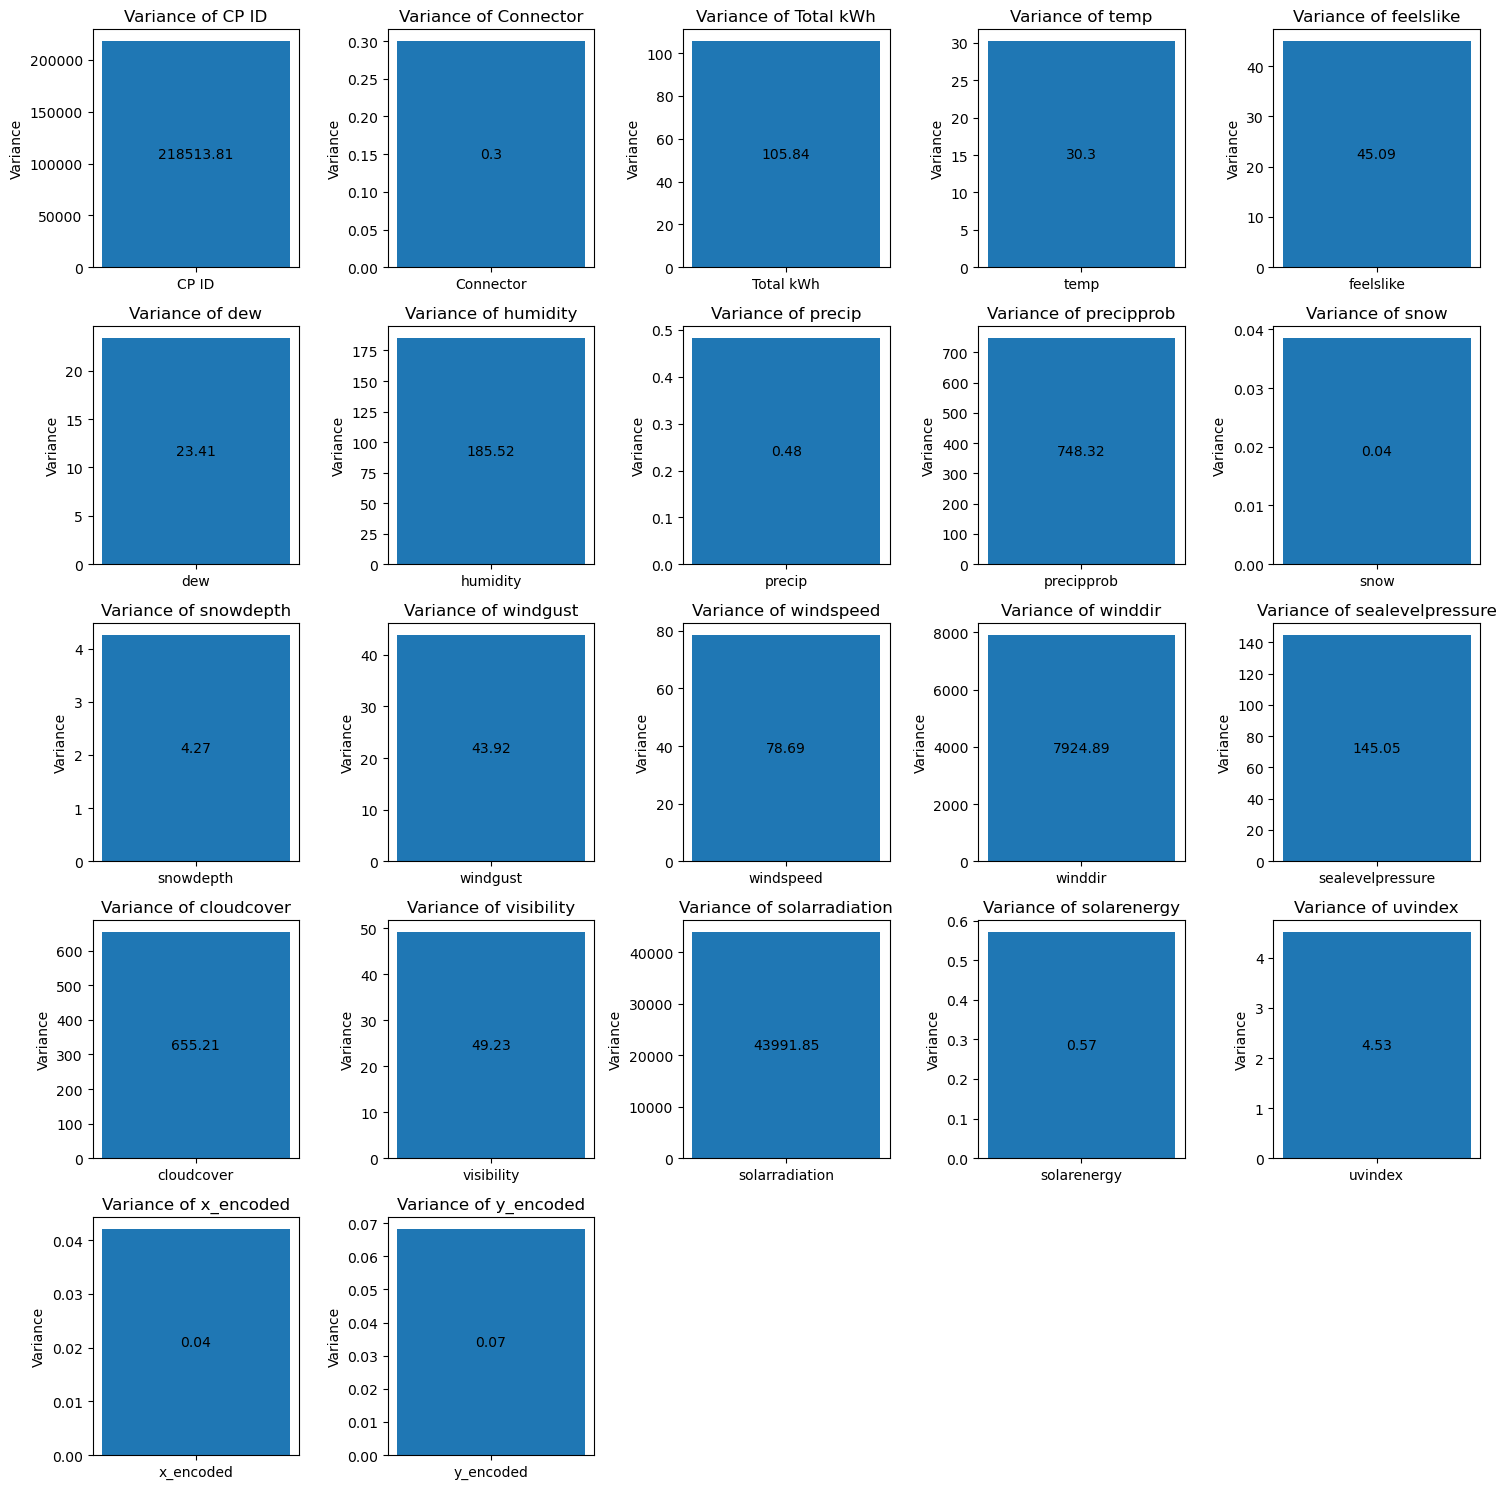

In [29]:
def calculate_feature_variances(df):
    """
    Calculate the variance of each column in a dataframe.
    Return a Series with the column name as the index and the variance as the value.
    """
    # Filter out non-numeric columns
    df_numeric = df.select_dtypes(include=[np.number])

    # Calculate variances
    variances = df_numeric.var()

    return variances

def plot_feature_variances(variances):
    """
    Plot the variance for each column in the variances Series
    and print the variance.
    """
    # Determine the grid size for the subplots
    grid_size = int(np.ceil(np.sqrt(len(variances))))

    # Create a grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.ravel()  # flatten axes

    # Print and plot each variance
    for i, (column, variance) in enumerate(variances.items()):
        print(f'Variance of {column}: {variance}')

        axes[i].bar(column, variance)
        axes[i].set_title(f'Variance of {column}')
        axes[i].set_ylabel('Variance')

        # Add the variance value inside the bar
        axes[i].text(column, variance / 2, round(variance, 2), ha='center', va='center')

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Usage:
variances = calculate_feature_variances(X_base)
plot_feature_variances(variances)

    If the 'Connector' feature is categorical and encoded as integers, then using VarianceThreshold may not be appropriate. VarianceThreshold is generally used for continuous numerical data. For categorical data, you might want to consider other methods of feature selection that are more appropriate for categorical data. For example, you could use chi-square test to test the independence between the categorical feature and the target variable. The features that are independent of the target variable can be dropped as they don't contribute to the model.

In [32]:
def plot_column_histograms_eu(dataframe, fig_size=(10, 5)):
    """
    Plot histograms for all numeric columns of a Pandas DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the columns to plot.
    fig_size (tuple): The size of the figure in inches (default: (10, 5)).

    Returns:
    None
    """
    # Select only numeric columns
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns

    # Determine the number of subplots and the number of rows and columns needed
    num_subplots = len(numeric_cols)
    num_cols = min(num_subplots, 4)
    num_rows = math.ceil(num_subplots / num_cols)

    # Create the figure and subplots
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fig_size, squeeze=False)

    # Remove any unused subplots
    for i in range(num_subplots, num_rows * num_cols):
        fig.delaxes(axs.flatten()[i])

    for i, col_name in enumerate(numeric_cols):
        try:
            row = i // num_cols
            col = i % num_cols
            axs[row, col].hist(dataframe[col_name], bins=40, facecolor='b', edgecolor='white')
            xlabel = col_name.split('_')[0]  # use the first part of the column name
            axs[row, col].set_title(f"{xlabel} Histogram")
            axs[row, col].set_xlabel(f'(range: {dataframe[col_name].min()} - {dataframe[col_name].max()})', rotation=0)  # rotate the label for better readability

            # Add y-axis label to the first column of histograms
            if col == 0:
                axs[row, col].set_ylabel("Frequency")
            else:
                axs[row, col].set_title(f"{xlabel} Histogram")

        except ValueError:
            print(f"Skipping column '{col_name}' because of 'ValueError: autodetected range of [nan, nan] is not finite'")

    fig.subplots_adjust(hspace=0.5)
    plt.show()

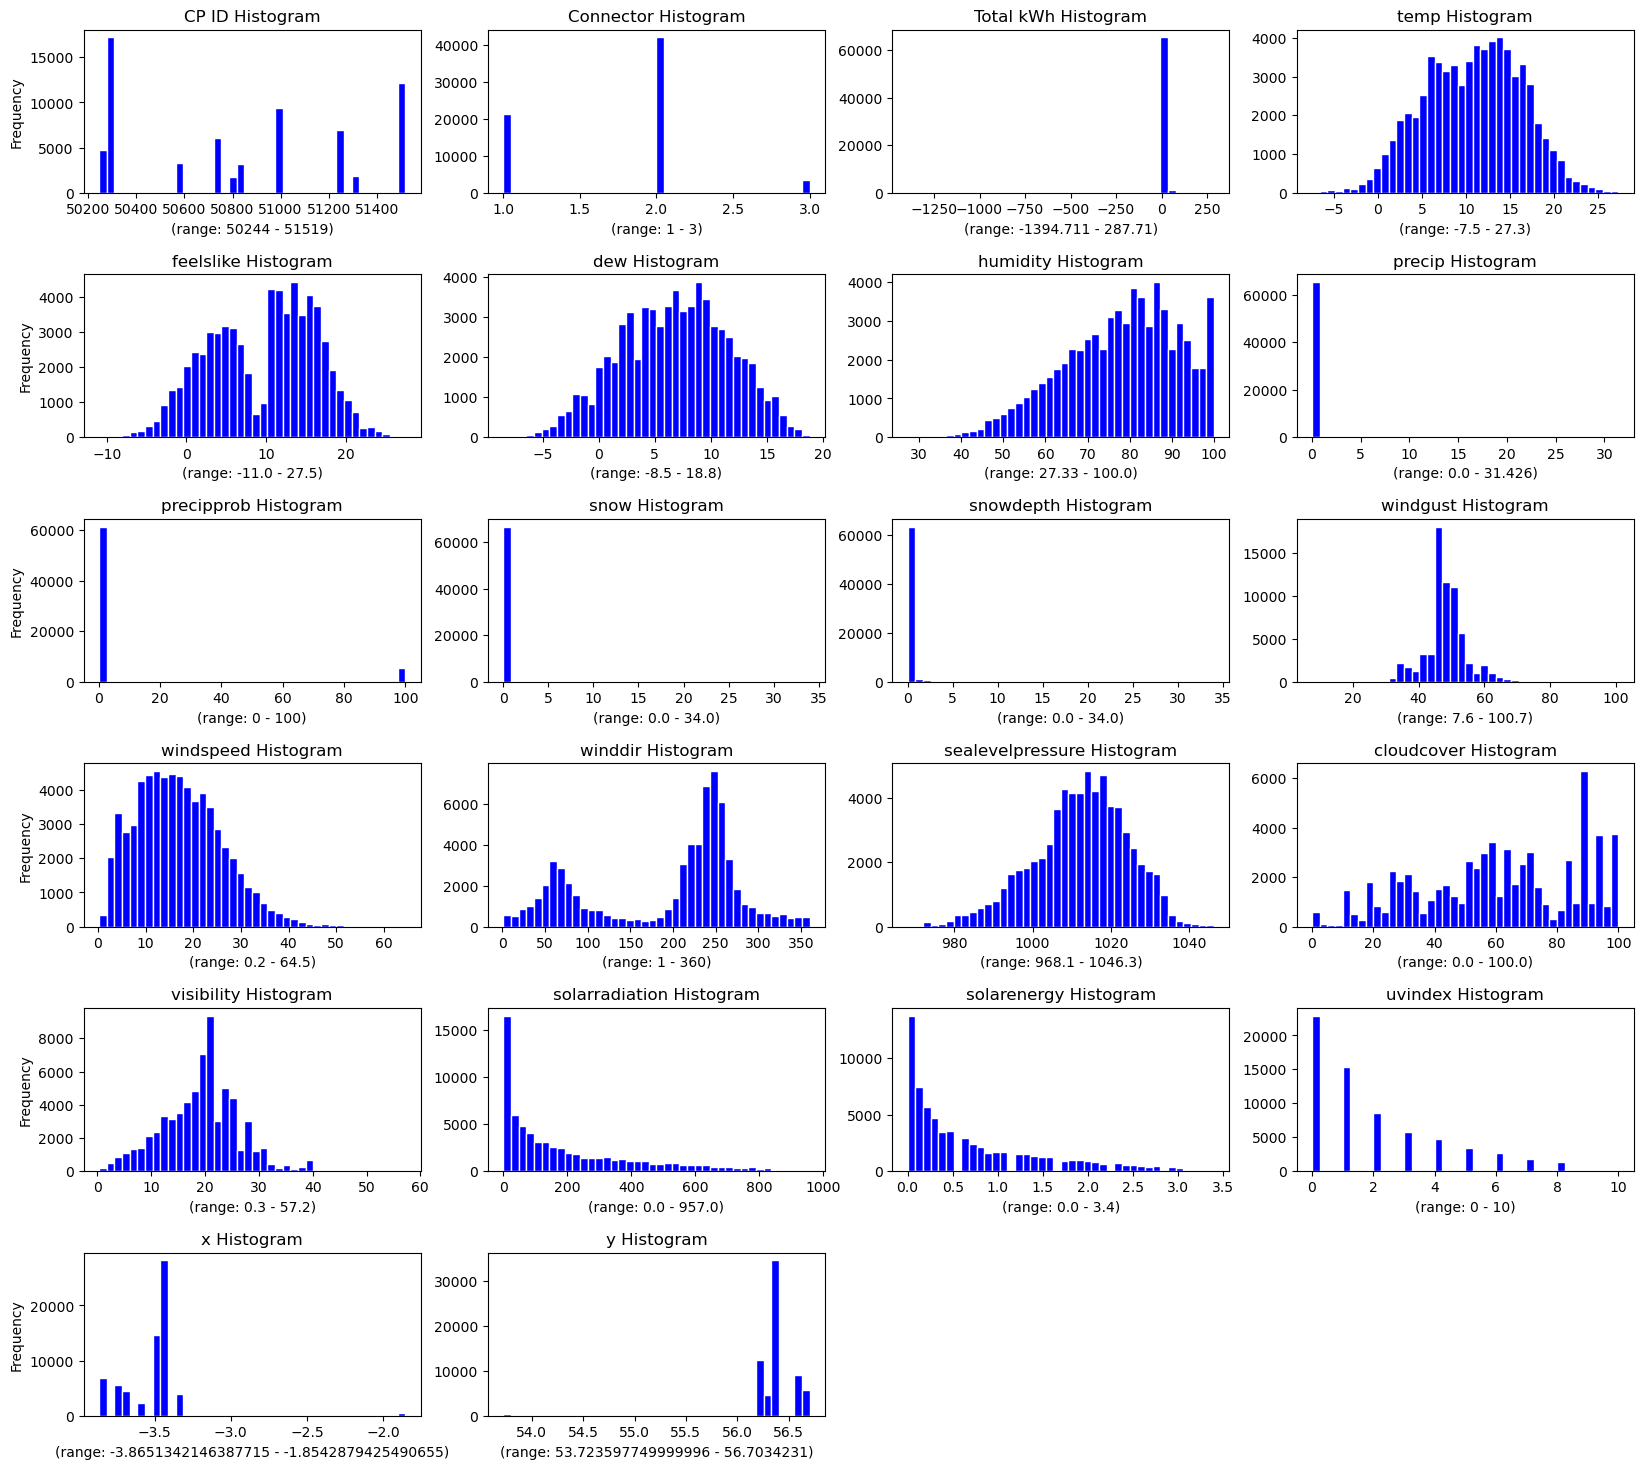

In [35]:
plot_column_histograms_eu(X_base, fig_size=(20, 18))

In [36]:
X_base.to_csv(os.path.join(cwd, '..', 'data', 'interim', 'data_encoded.csv'))

# Exploring time-related information

In [17]:
def data_wetaher():
    data_path = os.path.join(DATA_PATH, 'interim', 'data_encoded.csv') #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    # Drop 'Unnamed' columns
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    return data

X_base = data_wetaher()
# Display all columns
pd.set_option('display.max_columns', None)
X_base.head()

,Start DateTime,CP ID,Connector,Total kWh,End DateTime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,x_encoded,y_encoded
0,2016-01-09 07:21:00,50994,1,2.084,2016-01-09 07:27:00,-1.4,-1.4,-1.4,99.90,0.0,0,0.0,2.00,48.333737,0.2,354,990.9,98.4,1.0,0.0,0.0,0,-3.338015,56.591321
1,2016-01-09 07:51:00,50281,2,3.870,2016-01-09 09:01:00,-1.4,-1.4,-1.4,99.90,0.0,0,0.0,2.00,48.333737,0.2,354,990.9,98.4,1.0,0.0,0.0,0,-3.738821,56.703423
2,2016-01-09 08:22:00,50285,1,13.930,2016-01-09 14:32:00,-1.4,-1.4,-1.5,99.52,0.0,0,0.0,2.00,48.333737,0.2,354,989.9,98.9,1.4,0.7,0.0,0,-3.477746,56.386610
3,2016-01-09 08:54:00,50281,1,10.380,2016-01-09 16:37:00,-1.4,-1.4,-1.5,99.52,0.0,0,0.0,2.00,48.333737,0.2,354,989.9,98.9,1.4,0.7,0.0,0,-3.738821,56.703423
4,2016-01-09 09:22:00,50745,2,3.580,2016-01-09 09:37:00,-1.1,-1.1,-1.1,99.85,0.0,0,0.0,1.96,48.333737,0.2,1,989.5,97.0,0.7,12.7,0.0,0,-3.432945,56.206728


In [20]:
X_base.columns

Index(['Start DateTime', 'CP ID', 'Connector', 'Total kWh', 'End DateTime',
       'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'x_encoded', 'y_encoded'],
      dtype='object')

Given that your target variable is 'Total kWh' and you have a timestamp column 'Start DateTime', you 
can apply the decompose_time_series function to the 'Total kWh' column to visualize its trend, 
seasonality, and residuals over time. This can help to understand the underlying patterns in your target 
variable. 

The choice of 'additive' or 'multiplicative' model depends on the nature of your time series. If the trend 
and seasonal components of your time series seem to be constant over time (i.e., they do not depend 
on the level of the time series), an additive model is appropriate. If the trend and seasonal patterns 
seem to change in relation to the level of the time series (i.e., they increase when the time series 
increases), a multiplicative model is more appropriate. 

The frequency parameter is used to specify the number of data points in a single seasonal period. For 
example, if you have daily data and you suspect there's a weekly seasonality pattern, you would use 
freq=7. In your case, you would need to determine the appropriate frequency based on your 
knowledge of the data. If you're unsure, you could start with freq-I and adjust as necessary. 

Here's how you could modify the function for your data: 

In [21]:
def decompose_time_series(df, column='Total kWh', model='additive', freq=1):
    """
    This function decomposes a time series into trend, seasonality and noise.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the time series data.
    column (str): The column in the DataFrame containing the time series data. Default is 'Total kWh'.
    model (str): The type of decomposition model to use. Either 'additive' or 'multiplicative'. Default is 'additive'.
    freq (int): The frequency of the time series data. Default is 1.

    Returns:
    None. The function plots the original time series and its decomposed components.
    """

    # Check if the column exists in the DataFrame
    if column not in df.columns:
        raise ValueError(f"The column '{column}' does not exist in the DataFrame.")

    # Ensure the DataFrame is sorted by 'Start DateTime'
    df = df.sort_values('Start DateTime')

    # Decompose the time series
    result = seasonal_decompose(df[column], model=model, period=freq)

    # Plot the original time series and the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

    ax1.plot(df['Start DateTime'], df[column], label='Original')
    ax1.legend(loc='best')
    ax1.set_ylabel('Original')

    ax2.plot(df['Start DateTime'], result.trend, label='Trend')
    ax2.legend(loc='best')
    ax2.set_ylabel('Trend')

    ax3.plot(df['Start DateTime'], result.seasonal, label='Seasonality')
    ax3.legend(loc='best')
    ax3.set_ylabel('Seasonality')

    ax4.plot(df['Start DateTime'], result.resid, label='Residuals')
    ax4.legend(loc='best')
    ax4.set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

In [23]:
# Assume df is your DataFrame containing the 'load' column
decompose_time_series(X_base, column='Total kWh', model='additive', freq=1)